In [1]:
import os
import torch
import pandas as pd
import numpy as np
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from collections import OrderedDict
%matplotlib inline

In [2]:
dataset = ImageFolder('../input/stanford-dogs-dataset/images/Images')

In [3]:
len(dataset)

20580

In [4]:
breeds = []

def rename(name):
    return ' '.join(' '.join(name.split('-')[1:]).split('_'))

for n in dataset.classes:
    breeds.append(rename(n))

In [5]:
random_seed = 89
torch.manual_seed(random_seed)

In [6]:
from tqdm.notebook import tqdm

In [7]:
val_fr = 0.1
val_size = int(len(dataset)*val_fr)

train_size = int(len(dataset) - val_size)

In [8]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])

In [9]:
class dogs(Dataset):
    
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]

        if self.transform:
            img = self.transform(img)
        
        return img, label

In [10]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
    
])


val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

In [11]:
train_dataset = dogs(train_ds, train_transform)
val_dataset = dogs(val_ds, val_transform)

In [12]:
batch_size =64

train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size*2, num_workers=2, pin_memory=True)

In [13]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [14]:
class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
        return loss
    
    def validation_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
        acc = accuracy(out, targets)
        return {'val_acc':acc.detach(), 'val_loss':loss.detach()}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}
        
    def epoch_end(self, epoch, result):
        print("epoch [{}] : train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result["train_loss"], result["val_loss"], result["val_acc"]))

In [15]:
class dogsInceptionV3(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.wide_resnet50_2(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 120),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [16]:
model = dogsInceptionV3()

Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth


  0%|          | 0.00/132M [00:00<?, ?B/s]

In [17]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(d, device) for d in data]
    else:
        return data.to(device, non_blocking=True)

In [18]:
class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)

In [19]:
device = get_default_device()

train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)


to_device(model, device);

In [20]:
def try_batch(dl):
    for imgs, labels in dl:
        print("images shape : ", imgs.shape)
        print("labels : ", labels)
        outs = model(imgs)
        print("outs.shape :", outs.shape)
        print("outs : ", outs)
        break
        
try_batch(train_dl)

images shape :  torch.Size([64, 3, 224, 224])
labels :  tensor([ 17,  56,  72,  95, 108,  69,  22,  80,  10,   1,  94,  78, 113,  87,
         95,  38,  19,  23,  92,  22,  49,  49,  92,  95,  49,  77,  92,  63,
        109,   7,  13, 112,   5,  13,  60,   2,  21,  48,   9,  79, 103,  54,
         92,  23,  41, 118,  92,  15,  63,  18,   1,  87,  42,  35,  10,  40,
         52,  87,  14,  23, 108,  27,  26,  81], device='cuda:0')
outs.shape : torch.Size([64, 120])
outs :  tensor([[-4.6424, -4.2350, -5.1152,  ..., -4.7618, -4.8628, -4.3112],
        [-4.3907, -4.8764, -4.7781,  ..., -4.7090, -4.7402, -4.3421],
        [-4.8458, -4.5422, -4.7504,  ..., -4.8408, -4.0921, -5.0297],
        ...,
        [-4.7466, -4.5284, -4.9742,  ..., -4.5714, -4.8062, -4.6911],
        [-4.6450, -4.6155, -5.0443,  ..., -5.1058, -4.6199, -4.8510],
        [-4.7670, -4.5594, -4.6969,  ..., -4.9039, -4.2517, -4.6449]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)


In [21]:
from tqdm.notebook import tqdm

In [22]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func = torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # set up one cycle lr scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        
        # Training phase
        model.train()       
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            
            # calculates gradients
            loss.backward()
            
            # check gradient clipping 
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            # perform gradient descent and modifies the weights
            optimizer.step()
            
            # reset the gradients
            optimizer.zero_grad()
            
            # record and update lr
            lrs.append(get_lr(optimizer))
            
            # modifies the lr value
            sched.step()
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
        
    return history
        
    

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [23]:
evaluate(model, val_dl) 

{'val_loss': 4.828629493713379, 'val_acc': 0.015165440738201141}

In [24]:
num_epochs = 10
opt_func = torch.optim.SGD
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

In [25]:
history = fit_one_cycle(num_epochs, max_lr, model, train_dl, val_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/290 [00:00<?, ?it/s]

epoch [0] : train_loss: 2.9541, val_loss: 0.7878, val_acc: 0.8103


  0%|          | 0/290 [00:00<?, ?it/s]

epoch [1] : train_loss: 0.7363, val_loss: 0.8812, val_acc: 0.7319


  0%|          | 0/290 [00:00<?, ?it/s]

epoch [2] : train_loss: 0.6109, val_loss: 0.8661, val_acc: 0.7415


  0%|          | 0/290 [00:00<?, ?it/s]

epoch [3] : train_loss: 0.4999, val_loss: 1.1784, val_acc: 0.6745


  0%|          | 0/290 [00:00<?, ?it/s]

epoch [4] : train_loss: 0.3781, val_loss: 0.7761, val_acc: 0.7744


  0%|          | 0/290 [00:00<?, ?it/s]

epoch [5] : train_loss: 0.2771, val_loss: 0.7863, val_acc: 0.7636


  0%|          | 0/290 [00:00<?, ?it/s]

epoch [6] : train_loss: 0.1924, val_loss: 0.6750, val_acc: 0.7994


  0%|          | 0/290 [00:00<?, ?it/s]

epoch [7] : train_loss: 0.1099, val_loss: 0.5463, val_acc: 0.8480


  0%|          | 0/290 [00:00<?, ?it/s]

epoch [8] : train_loss: 0.0668, val_loss: 0.4930, val_acc: 0.8590


  0%|          | 0/290 [00:00<?, ?it/s]

epoch [9] : train_loss: 0.0480, val_loss: 0.4871, val_acc: 0.8627


In [26]:
num_epochs = 5
max_lr = 0.001
history += fit_one_cycle(num_epochs, max_lr, model, train_dl, val_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/290 [00:00<?, ?it/s]

epoch [0] : train_loss: 0.0473, val_loss: 0.4944, val_acc: 0.8608


  0%|          | 0/290 [00:00<?, ?it/s]

epoch [1] : train_loss: 0.0451, val_loss: 0.4941, val_acc: 0.8553


  0%|          | 0/290 [00:00<?, ?it/s]

epoch [2] : train_loss: 0.0409, val_loss: 0.4975, val_acc: 0.8599


  0%|          | 0/290 [00:00<?, ?it/s]

epoch [3] : train_loss: 0.0389, val_loss: 0.4860, val_acc: 0.8627


  0%|          | 0/290 [00:00<?, ?it/s]

epoch [4] : train_loss: 0.0368, val_loss: 0.4860, val_acc: 0.8622


In [27]:
num_epochs = 3
max_lr = 0.0001
history += fit_one_cycle(num_epochs, max_lr, model, train_dl, val_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/290 [00:00<?, ?it/s]

epoch [0] : train_loss: 0.0371, val_loss: 0.4945, val_acc: 0.8604


  0%|          | 0/290 [00:00<?, ?it/s]

epoch [1] : train_loss: 0.0373, val_loss: 0.4913, val_acc: 0.8608


  0%|          | 0/290 [00:00<?, ?it/s]

epoch [2] : train_loss: 0.0348, val_loss: 0.4881, val_acc: 0.8627


In [28]:
history[0].keys()

dict_keys(['val_loss', 'val_acc', 'train_loss', 'lrs'])

In [29]:
val_loss = []
train_loss = []
val_acc = []
time = list(range(len(history)))
for h in history:
    val_loss.append(h['val_loss'])
    train_loss.append(h['train_loss'])
    val_acc.append(h['val_acc'])

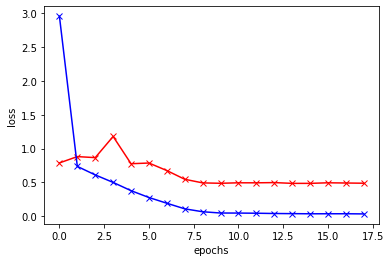

In [30]:
plt.plot(time, val_loss, c='red', label='val_loss', marker='x')
plt.plot(time, train_loss, c='blue', label='train_loss', marker='x')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

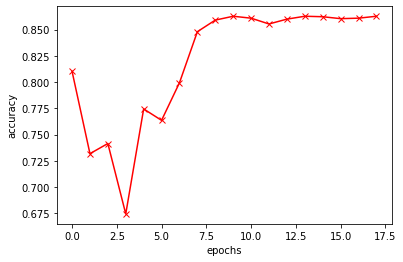

In [31]:
plt.plot(time, val_acc, c='red', label='accuracy', marker='x')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [32]:
weights = './dog-breed-classifier.pth'
torch.save(model.state_dict(), weights)

In [47]:
def predict_single(img):
    test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),])
    img = test_transform(img)
#     xb = torch.permute(img, (2, 0, 1))
    xb = img.unsqueeze(0) # adding extra dimension
    xb = to_device(xb, device)
    preds = model(xb)                   # change model object here
    predictions = preds[0]
    
    max_val, kls = torch.max(predictions, dim=0)
    print('| Predicted :', breeds[kls])
    plt.imshow(img.permute(1,2,0))
    plt.show()

| Predicted : German shepherd


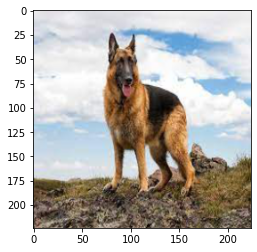

In [48]:
predict_single(Image.open("../input/testmodel/download.jpg"))